In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [3]:
tweet= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

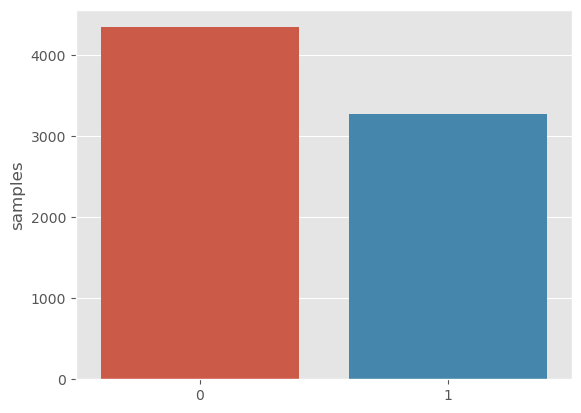

In [5]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

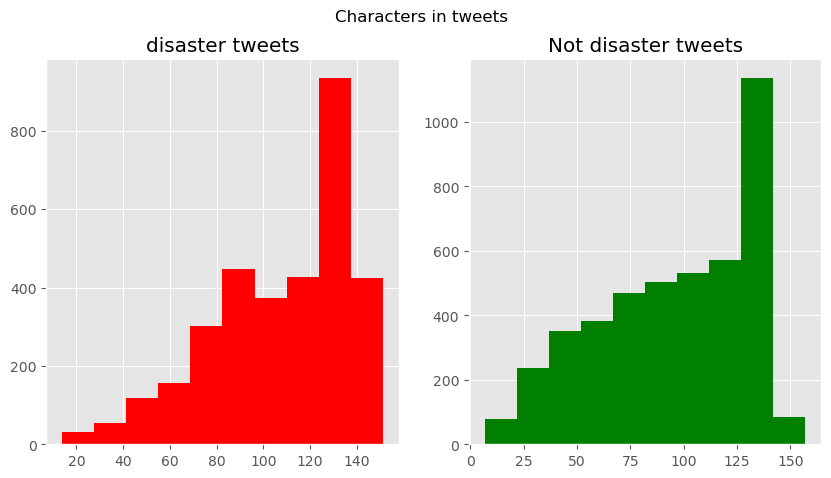

In [6]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

In [7]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

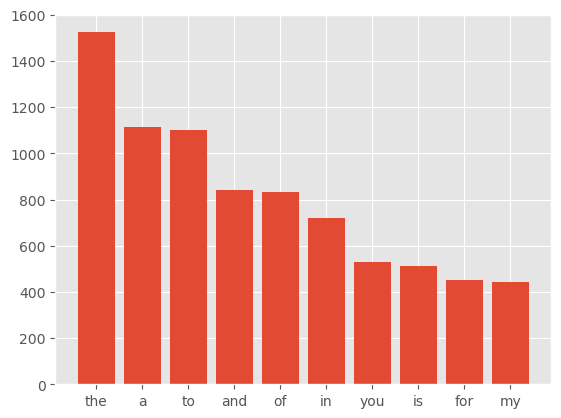

In [8]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

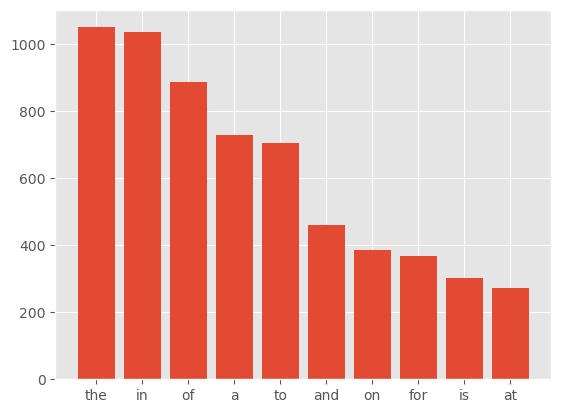

In [9]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 18 artists>

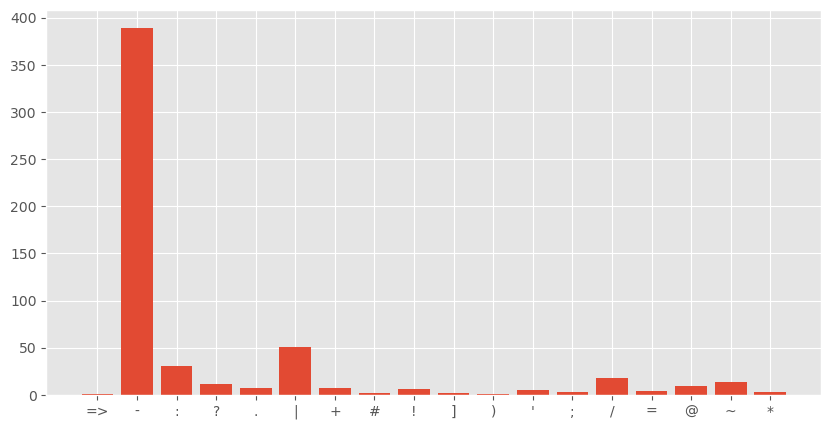

In [10]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

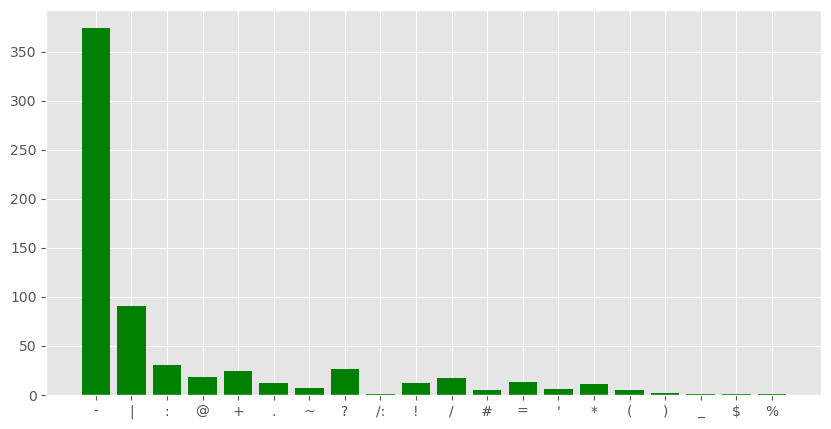

In [11]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [12]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<AxesSubplot:>

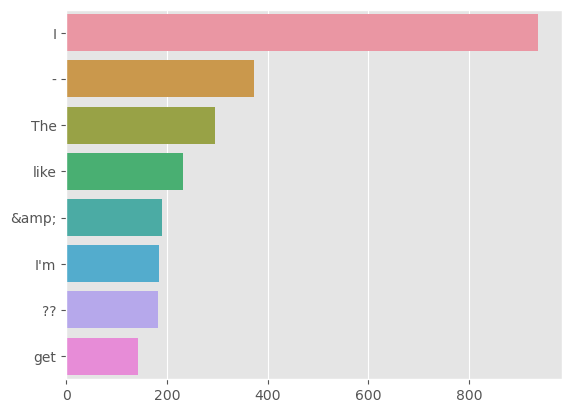

In [13]:
sns.barplot(x=y,y=x)

In [14]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

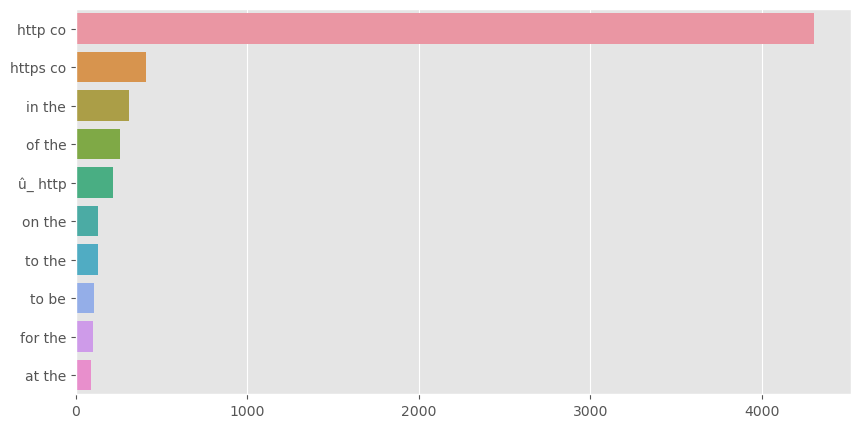

In [15]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [16]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

In [17]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [18]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [19]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [20]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [21]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [22]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [23]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [24]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [25]:
!pip install pyspellchecker

     ---------------------------------------- 3.4/3.4 MB 9.1 MB/s eta 0:00:00


In [26]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me plese'

In [28]:
# df['text']=df['text'].apply(lambda x : correct_spellings(x))

TypeError: sequence item 2: expected str instance, NoneType found

In [29]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
        
    
corpus=create_corpus(df)

100%|██████████████████████████████████████████████████████████████████████████| 10876/10876 [00:01<00:00, 7786.62it/s]


In [33]:
%%time

glove_embeddings = np.load('glove.840B.300d.pkl', allow_pickle=True)

# embedding_dict={}
# with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
#     for line in f:
#         values=line.split()
#         word=values[0]
#         vectors=np.asarray(values[1:],'float32')
#         embedding_dict[word]=vectors
# f.close()

Wall time: 34.8 s


In [34]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

Number of unique words: 20342


100%|███████████████████████████████████████████████████████████████████████| 20342/20342 [00:00<00:00, 1303140.71it/s]


In [35]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2034300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [36]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [37]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [38]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1618/1618 - 109s - loss: 0.6908 - accuracy: 0.5685 - val_loss: 0.6876 - val_accuracy: 0.5709 - 109s/epoch - 67ms/step
Epoch 2/15
1618/1618 - 145s - loss: 0.6851 - accuracy: 0.5702 - val_loss: 0.6833 - val_accuracy: 0.5709 - 145s/epoch - 89ms/step
Epoch 3/15
1618/1618 - 112s - loss: 0.6835 - accuracy: 0.5702 - val_loss: 0.6831 - val_accuracy: 0.5709 - 112s/epoch - 69ms/step
Epoch 4/15
1618/1618 - 98s - loss: 0.6834 - accuracy: 0.5702 - val_loss: 0.6831 - val_accuracy: 0.5709 - 98s/epoch - 61ms/step
Epoch 5/15
1618/1618 - 112s - loss: 0.6834 - accuracy: 0.5702 - val_loss: 0.6831 - val_accuracy: 0.5709 - 112s/epoch - 69ms/step
Epoch 6/15
1618/1618 - 147s - loss: 0.6833 - accuracy: 0.5702 - val_loss: 0.6831 - val_accuracy: 0.5709 - 147s/epoch - 91ms/step
Epoch 7/15
1618/1618 - 105s - loss: 0.6835 - accuracy: 0.5702 - val_loss: 0.6831 - val_accuracy: 0.5709 - 105s/epoch - 65ms/step
Epoch 8/15
1618/1618 - 106s - loss: 0.6835 - accuracy: 0.5702 - val_loss: 0.6831 - val_accuracy: 0.

KeyboardInterrupt: 

In [39]:
sample_sub=pd.read_csv('sample_submission.csv')

y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

sub.head()

102/102 [==============================] - 3s 26ms/step


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
